Experiment for the paper "Features for discourse-new referent detection in Russian
==============================================
Replication of CICLing-2016 paper
-------------------------------------

To reproduce this experiment you will need:
1. [RuCor corpus (from 2015-10-29)](http://rucoref.maimbava.net/files/rucoref_29.10.2015.zip)
2. [`scikit-learn`](http://scikit-learn.org/stable/install.html), [`unbalanced-dataset`](https://github.com/fmfn/UnbalancedDataset), [`matplotlib`](http://matplotlib.org/users/installing.html) Python modules
2. `anaphoralib` [Python module](https://github.com/max-ionov/rucoref)

Since `anaphoralib` is in an early stage of development, there is no way to install it yet, so in order to import it, you should `cd` to the folder with the module. Paths to the corpus should be updated accordingly.

In [1]:
%cd '/media/max/Extension/Projects/Coreference/'

/media/max/Extension/Projects/Coreference


In [2]:
from anaphoralib.corpora import rueval
from anaphoralib.tagsets import multeast
from anaphoralib.experiments.base import BaseClassifier
from anaphoralib import utils

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from unbalanced_dataset import SMOTE

import numpy as np

%matplotlib inline

In [5]:
lists_dir = 'CICLing-2016/wordlists'
texts_dir = 'Corpus-2015/Tokens.txt'
gs_dir = 'Corpus-2015/Groups.txt'

tagset = multeast

random_state = 42

Reading the texts from GS and matching them to actual texts
--------------

### Loading chains and GS

In [3]:
rucoref = rueval.RuCorefCorpus(multeast, rueval)

In [6]:
rucoref.load_texts(texts_dir)
rucoref.load_gs(gs_dir)

In [7]:
rucoref.find_groups()

In [8]:
rucoref.groups[0][:10]

[Во(Sp-a, 0),
 время своих прогулок(Ncnsan, 3),
 в(Sp-l, 24),
 окрестностях Симеиза(Ncfpln, 26),
 я(P-1-snn, 47),
 обратил(Vmis-sma-p, 49),
 внимание(Ncnsan, 57),
 на(Sp-a, 66),
 одинокую дачу(Ncfsan, 69),
 стоявшую(Vmps-sfa-ea, 84)]

In [9]:
rucoref.print_stats()

Number of texts: 181
Number of GS texts: 181
Number of chains in a corpus: 3638
Number of words in all chains: 16557


In [10]:
rucoref.create_indices()

### Loading special lists
Special lists load from the directory stored in `lists_dir`

In [11]:
import codecs

def load_list(filename):
    data = set()
    with codecs.open(filename, encoding='utf-8') as inp_file:
        for line in inp_file:
            data.add(line.strip('\r\n'))
    
    return data

In [12]:
import os

wordlists = {}

for filename in os.listdir(lists_dir):
    wordlists[filename.replace('.txt', '')] = load_list(os.path.join(lists_dir, filename))

In [13]:
print wordlists.keys()

['refer_to_CommKnowl', 'adj-top50', 'role_assess', 'NewRef', 'non-identity_sim', 'possessives', 'subjectivity', 'class', 'demonstratives', 'indef']


### Building indices and dictionaries

Building additional indices (of all words and all groups):

In [14]:
import collections

word_index = []
group_index = []

for i, text in enumerate(rucoref.texts):
    word_index.append(collections.defaultdict(set))
    group_index.append(collections.defaultdict(set))
    
    for word in text:
        word_index[-1]['_'.join(word.lemma)].add(word.offset)
    for group in rucoref.groups[i]:
        for g in group.iter_groups():
            group_index[-1]['_'.join(g.lemma)].add(g.offset)

In [15]:
print '\n'.join(group_index[0].keys()[:15])

спокойно
кой
другой_сторона_можжевелового_куст
линия
поднять
прежде
кругом
подставить
хотя
и
хоть
случиться
вышележащие
поддерживать
небольшой


Building sets of adjectives and pronouns for feature selection:

In [16]:
adjectives = set()
for text in rucoref.texts:
    for word in text:
        if tagset.pos_filters['adj'](word) and (len(word.tag) < 7 or word.tag[6] == 'f'):
            adjectives.add('_'.join(word.lemma))

adjectives = list(adjectives)

In [17]:
pronouns = set()
for text in rucoref.texts:
    for word in text:
        if tagset.pos_filters['pronoun'](word):
            pronouns.add('_'.join(word.lemma))

pronouns = list(pronouns)

### Creating a classifier

In [18]:
import re

class FirstMentionClassifier(BaseClassifier):
    def __init__(self):
        super(FirstMentionClassifier, self).__init__()
        
        self.feat_zones_ = ('struct', 'string', 'lists')
        self.stats = {'str_matches_before', 'head_matches_before', 'n_adj', 'len_np'}
        
        self.rx_lat = re.compile('[A-Za-z]')
        self.pronouns = {u"его", u"ее", u"её", u"ей", u"ему", u"ею", u"им", u"ими", u"их", u"которая", 
                u"которого", u"которое", u"которой", u"котором", u"которому", u"которую", u"которые", 
                u"который", u"которым", u"которыми", u"которых", u"него", u"нее", u"неё", u"ней", u"нем", 
                u"нём", u"нему", u"нею", u"ним", u"ними", u"них", u"он", u"она", u"они", u"оно", u"свое", 
                u"своё", u"своего", u"своей", u"своем", u"своём", u"своему", u"своею", u"свой", u"свои", 
                u"своим", u"своими", u"своих", u"свою", u"своя", u"себе", u"себя", u"собой", u"собою"}
        
        self.clear_stats()
        
    def get_feature_vector(self, corpus, group, i_text, save_feature_names=False):
        if save_feature_names:
            self.feature_names_ = []
            
        vctr = []
        
        group_lemma = '_'.join(group.lemma)
        group_occurrences = group_index[i_text][group_lemma] if group_lemma in group_index[i_text] else []

        head_index = group.head
        head_lemma = group.lemma[group.head]
        head_occurrences = word_index[i_text][head_lemma] if head_lemma in word_index[i_text] else []
        head_offset = group.head_offset

        group_words = group.words if group.type != 'word' else [group]

        str_matches_before = sum(1 for occ in group_occurrences if occ < group.offset)
        head_matches_before = sum(1 for occ in head_occurrences if occ < group.offset)
        
        adj_in_group = [word for word in group_words[:head_index+1] if tagset.pos_filters['adj'](word)]
        
        self.stats['str_matches_before'].append(str_matches_before)
        self.stats['head_matches_before'].append(head_matches_before)
        
        self.stats['n_adj'].append(len(adj_in_group))
        self.stats['len_np'].append(len(group_words))
        
        if 'string' in self.feat_zones_:
            vctr.append(('str_match_before=0', str_matches_before == 0))
            vctr.append(('str_match_before<2', str_matches_before < 2))
            vctr.append(('str_match_before<3', str_matches_before < 3))
            vctr.append(('str_match_before>2', str_matches_before > 2))

            vctr.append(('head_match_before=0', head_matches_before == 0))
            vctr.append(('head_match_before<2', head_matches_before < 2))
            vctr.append(('head_match_before<3', head_matches_before < 3))
            vctr.append(('head_match_before>2', head_matches_before > 2))
            
            vctr.append(('uppercase', all(word.isupper() and len(word) > 1 for word in group.wordform)))
            #vctr.append(('capitalized', any(word[0].isupper() and len(group.wordform) > 1 for word in group.wordform[1:])))
            vctr.append(('latin', any(self.rx_lat.search(word) for word in group.wordform)))
            vctr.append(('is_proper_noun', corpus.tagset.pos_filters['properNoun'](group)))
        vctr.append(('is_pronoun', group.wordform[0] in pronouns))
        
        if 'struct' in self.feat_zones_:
            i_word = corpus.words_index[i_text][group.offset]
            left_word = corpus.texts[i_text][i_word - 1] if i_word > 0 else None
            right_word = corpus.texts[i_text][i_word + len(group.wordform) + 1] \
                                if i_word + len(group.wordform) + 1 < len(corpus.texts[i_text]) else None
            vctr.append(('conj', bool((left_word and corpus.tagset.pos_filters['conj'](left_word)) 
                        or (right_word and corpus.tagset.pos_filters['conj'](right_word)))))
            
            vctr.append(('len_np<2', len(group.tags) < 2))
            vctr.append(('len_np>2', len(group.tags) > 2))
            
            vctr.append(('n_adj=0', len(adj_in_group) == 0))
            vctr.append(('n_adj>1', len(adj_in_group) > 1))
            vctr.append(('n_adj>2', len(adj_in_group) > 2))
            
        if 'lists' in self.feat_zones_:
            for l in wordlists:
                vctr.append(('in_list_{}'.format(l), any(lemma in wordlists[l] for lemma in group.lemma[:head_index+1])))
        
        if save_feature_names:
            self.feature_names_ = [feat[0] for feat in vctr]
        
        return [feat[1] for feat in vctr]
    
    def prepare_data(self, corpus, random_state=42, test_size=0.3, feature_zones=None):
        if feature_zones:
            self.feat_zones_ = feature_zones
        
        self.groups = []
        self.x_data = []
        self.y_data = []

        self.cur_data_ = 'Binary, filtered singletons'
        self.class_names_ = ('non-first', 'first')
        
        save_features = True
    
        for i_text, text in enumerate(corpus.texts):
            for i, mention in enumerate(corpus.mentions[i_text]):
                if i not in rucoref.gs_index[i_text]:
                    continue
                else:
                    cur_gs_group_id = corpus.gs_index[i_text][i]
                    cur_chain = corpus.gs[i_text]['chains'][corpus.chains_index[i_text][cur_gs_group_id]]

                    self.y_data.append(self.class_names_.index('first') if cur_gs_group_id == cur_chain[0] 
                                       else self.class_names_.index('non-first'))

                group = corpus.heads_index[i_text][mention.offset]
                self.x_data.append(self.get_feature_vector(corpus, group, i_text, save_features))
                self.groups.append(group)
                save_features = False

                #pronoun_index = self.feature_names_.index('is_pronoun')
                #if self.x_data[-1][pronoun_index]:
                #    self.x_data.pop()
                #    self.y_data.pop()
                #    continue
                
                #del self.x_data[-1][pronoun_index]
            
            super(FirstMentionClassifier, self).prepare_data(corpus, random_state, test_size)
    
        #del self.feature_names_[pronoun_index]
        class_numbers = [sum(1 for item in self.y_data if item == cur_class) for cur_class in range(len(self.class_names_))]
        self.ratio = float(max(class_numbers) / float(min(class_numbers)))

### Training and testing

In [19]:
first_mention_clf = FirstMentionClassifier()
first_mention_clf.prepare_data(rucoref, random_state=random_state)

#### Baseline

In [20]:
def baseline_predict(data):
    y_pred = np.zeros(len(data))
    for i, row in enumerate(data):
        y_pred[i] = row[0] == 1
    
    return y_pred

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


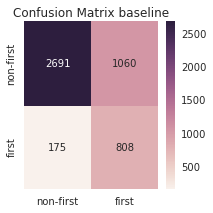

Report baseline:              precision    recall  f1-score   support

  non-first      0.939     0.717     0.813      3751
      first      0.433     0.822     0.567       983

avg / total      0.834     0.739     0.762      4734



In [21]:
first_mention_clf.test(y_pred=baseline_predict(first_mention_clf.x_data_test), test_name='baseline')

#### String features

In [24]:
first_mention_clf.prepare_data(rucoref, random_state=random_state, feature_zones=('string',))

In [25]:
clf = RandomForestClassifier(n_estimators=200, random_state=random_state)
sampler = sampler=SMOTE(ratio=first_mention_clf.ratio, verbose=False, kind='borderline1', random_state=random_state)

first_mention_clf.fit(clf, sampler)

In [26]:
first_mention_clf.print_stats()

Classifier <class 'sklearn.ensemble.forest.RandomForestClassifier'>: fitted
Data: Binary, filtered singletons (non-first, first)
Total:	15778 samples
	12367 non-first
	3411 first


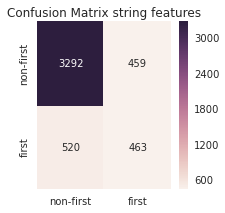

Report string features:              precision    recall  f1-score   support

  non-first      0.864     0.878     0.871      3751
      first      0.502     0.471     0.486       983

avg / total      0.789     0.793     0.791      4734



In [27]:
first_mention_clf.test(test_name='string features')

#### String + Struct features

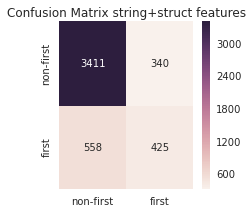

Report string+struct features:              precision    recall  f1-score   support

  non-first      0.859     0.909     0.884      3751
      first      0.556     0.432     0.486       983

avg / total      0.796     0.810     0.801      4734



In [28]:
first_mention_clf = FirstMentionClassifier()
first_mention_clf.prepare_data(rucoref, random_state=random_state, feature_zones=('string', 'struct'))
clf = RandomForestClassifier(n_estimators=200, random_state=random_state)
sampler = sampler=SMOTE(ratio=first_mention_clf.ratio, verbose=False, kind='borderline1', random_state=random_state)

first_mention_clf.fit(clf, sampler)
first_mention_clf.test(test_name='string+struct features')

#### All features

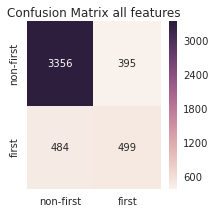

Report all features:              precision    recall  f1-score   support

  non-first      0.874     0.895     0.884      3751
      first      0.558     0.508     0.532       983

avg / total      0.808     0.814     0.811      4734



In [29]:
first_mention_clf = FirstMentionClassifier()
first_mention_clf.prepare_data(rucoref, random_state=random_state, feature_zones=('string', 'struct', 'lists'))
clf = RandomForestClassifier(n_estimators=200, random_state=random_state)
sampler = sampler=SMOTE(ratio=first_mention_clf.ratio, verbose=False, kind='borderline1', random_state=random_state)

first_mention_clf.fit(clf, sampler)
first_mention_clf.test(test_name='all features')

### Calculating feature importances

In [30]:
regr = LogisticRegression(random_state=random_state)
sampler = sampler=SMOTE(ratio=first_mention_clf.ratio, verbose=False, kind='borderline1', random_state=random_state)

first_mention_clf.fit(regr, sampler)

In [31]:
for i, feat_name in enumerate(first_mention_clf.feature_names_):
    print '{}: {:.4f}'.format(feat_name, regr.coef_[0,i])

str_match_before=0: 3.4677
str_match_before<2: 0.0777
str_match_before<3: -0.1559
str_match_before>2: -0.3620
head_match_before=0: 0.0000
head_match_before<2: -1.2529
head_match_before<3: 0.1394
head_match_before>2: -0.6573
uppercase: 0.8062
latin: 0.6509
is_proper_noun: 0.6052
is_pronoun: -2.5728
conj: 0.6600
len_np<2: 0.0440
len_np>2: 0.5115
n_adj=0: -1.4085
n_adj>1: 0.3295
n_adj>2: -2.4720
in_list_refer_to_CommKnowl: -0.0688
in_list_adj-top50: 1.7717
in_list_role_assess: -0.2438
in_list_NewRef: -1.0547
in_list_non-identity_sim: -0.0126
in_list_possessives: -2.7852
in_list_subjectivity: -0.5373
in_list_class: 4.0993
in_list_demonstratives: -1.7207
in_list_indef: 3.9282


## Additional actions

### Counting feature importances for bag-of-adjectives classifier

In [32]:
import sklearn.feature_extraction.text
adj_vectorizer = sklearn.feature_extraction.text.CountVectorizer(vocabulary=adjectives)
pron_vectorizer = sklearn.feature_extraction.text.CountVectorizer(vocabulary=pronouns)

In [33]:
def additional_features(data, vectorizer):
    additional_features = np.zeros(shape=(len(data), len(vectorizer.vocabulary)))
    for i, row in enumerate(data):
        additional_features[i,:] = vectorizer.transform([u' '.join(row.lemma)]).toarray()
    
    return additional_features

In [34]:
from sklearn.preprocessing import MinMaxScaler

def rank_to_dict(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x, 4), ranks)
    return dict(zip(names, ranks ))

In [35]:
add_data_x = additional_features(first_mention_clf.groups_train, adj_vectorizer)
adj_clf = RandomForestClassifier(random_state=random_state)
adj_clf.fit(add_data_x, first_mention_clf.y_data_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [36]:
ranks = rank_to_dict(adj_clf.feature_importances_, adj_vectorizer.vocabulary)

for feat_name in sorted(ranks, key=lambda f: ranks[f], reverse=True):
    print feat_name, ranks[feat_name]

который 1.0
его 0.5134
свой 0.4834
ее 0.1631
собственный 0.1559
каждый 0.1531
некоторые 0.1435
русский 0.1292
небольшой 0.1275
другой 0.1275
главный 0.1245
первый 0.1234
новый 0.1231
их 0.1177
исторический 0.1013
основной 0.1011
местный 0.0969
единственный 0.0941
огромный 0.0901
такой 0.0891
социальный 0.0793
мелкий 0.0767
глобальный 0.0762
деревянный 0.0736
радиоактивный 0.0733
разный 0.0679
мой 0.0642
вооруженный 0.0638
высокий 0.0622
женский 0.0599
ранний 0.0595
природный 0.0591
иностранный 0.0589
знакомый 0.0587
общественный 0.0537
утекшую 0.0528
трудовой 0.0522
кредитный 0.0519
сильный 0.0508
исламское 0.0505
европейский 0.0497
твердый 0.0495
международный 0.0493
окружной 0.0486
рабочий 0.0486
земной 0.0479
хороший 0.0474
необычный 0.0468
радикальный 0.0468
юный 0.0467
московский 0.0465
региональный 0.0449
колокольной 0.0445
палестинское 0.0444
синий 0.0442
математический 0.0441
северокорейский 0.044
разрушительного 0.0438
алый 0.0437
западный 0.0431
экономический 0.0424
динамичны

### Getting feature distributions

In [ ]:
feature_groups = ('string', 'struct', 'lists')
x_data, y_data, feature_names, ratio = get_features_binary_no_singletons(feature_groups)

In [ ]:
new_x_data = [(feature_values[i], x_data[i]) for i in range(len(x_data))]

In [ ]:
from sklearn import cross_validation
x_data_train, x_data_test, y_data_train, y_data_test = cross_validation.train_test_split(new_x_data, 
                                                                                         y_data, 
                                                                                         test_size=0.3,
                                                                                         random_state=42)

In [ ]:
feature_values_train = [item[0] for item in x_data_train]

In [ ]:
x_data_train = [item[1] for item in x_data_train]
x_data_test = [item[1] for item in x_data_test]

In [ ]:
feature_distributions = {feat_name: {cls: [] for cls in class_names + ('total',)} 
                         for feat_name in feature_values_train[0]}

In [ ]:
for i, row in enumerate(feature_values_train):
    cur_key = class_names[int(y_data_train[i])]
    for feat_name in row:
        feature_distributions[feat_name][cur_key].append(row[feat_name])
        feature_distributions[feat_name]['total'].append(row[feat_name])

In [ ]:
feature_distributions['n_adj']['first'][:10]

In [ ]:
feature_distributions.keys()

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [ ]:
from math import sqrt
SPINE_COLOR = 'gray'

In [ ]:
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': ['\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'text.fontsize': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

In [ ]:
latexify()

In [ ]:
def plot_feat_distribution(distribution, x_label='Feature value', filename='plot.pdf'):
    bins = range(5)
    
    ax = plt.gca()
    ax.set_xlabel(x_label)
    ax.set_ylabel("Density")
    #ax.set_title("Distribution of feature")
    plt.tight_layout()
    format_axes(ax)
    
    #plt.hist(distribution['first'], color="0.1", bins=bins, alpha=0.5, label='first', normed=True)
    #plt.hist(distribution['non-first'], color="0.8", bins=bins, alpha=0.5, label='non-first', normed=True)
    #plt.savefig("{}.pdf".format(filename))
    #plt.show()
    #plt.close()
    
    first_hist = np.histogram(distribution['first'], bins, normed=True)
    nonfirst_hist = np.histogram(distribution['non-first'], bins, normed=True)
    
    w = 0.3
    
    first_x = [item for item in range(len(first_hist[0]))]
    non_first_x = [item+w for item in range(len(nonfirst_hist[0]))]
    
    ax.set_xticks([item + float(w) for item in first_x])
    ax.set_xticklabels(first_x)
    
    rects1 = plt.bar(non_first_x, nonfirst_hist[0], w, color='0.3')
    rects2 = plt.bar(first_x, first_hist[0], w, color='0.7')
    plt.legend((rects1, rects2), class_names, loc='upper right')
    
    print class_names
    
    plt.savefig("{}.pdf".format(filename))
    plt.show()
    plt.close()

In [ ]:
plot_feat_distribution(feature_distributions['n_adj'], x_label='\# of adjectives', filename='n_adj')
plot_feat_distribution(feature_distributions['len_np'], x_label='Length of NP (words)', filename='len_np')

In [ ]:
plot_feat_distribution(feature_distributions['str_matches_before'], 
                       x_label='\# of NP occurrences before', filename='n_np')
plot_feat_distribution(feature_distributions['head_matches_before'], 
                       x_label='\# of NP head occurrences before', filename='n_head')

In [ ]:
plot_feat_distribution(feature_distributions['str_matches_before'], filename='str_matches_before')

In [ ]:
plot_feat_distribution(feature_distributions['head_matches_before'], filename='head_matches_before')